### categorical feature encoding

In [ ]:
# 0.50000, 0.57334 - 0.61590

In [23]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [24]:
# read files
df_test = pd.read_csv(r'...kaggle\categorical\test.csv',index_col='id')
df_train = pd.read_csv(r'...kaggle\categorical\train.csv',index_col='id')
df = pd.concat([df_train, df_test],axis=0,ignore_index=True) # combine training and testing data

In [25]:
# unitlity function to describe dataframe summary
def desc(df):
    summ = pd.DataFrame(df.dtypes,columns=['Data_Types'])
    summ = summ.reset_index()
    summ['Columns'] = summ['index']
    summ = summ[['Columns','Data_Types']]
    summ['Missing'] = df.isnull().sum().values    
    summ['Uniques'] = df.nunique().values
    return summ

# utility function to analyse missing values
def nulls_report(df):
    nulls = df.isnull().sum()
    nulls = nulls[df.isnull().sum()>0].sort_values(ascending=False)
    nulls_report = pd.concat([nulls, nulls / df.shape[0]], axis=1, keys=['Missing_Values','Missing_Ratio'])
    return nulls_report


In [ ]:
desc(df_train)

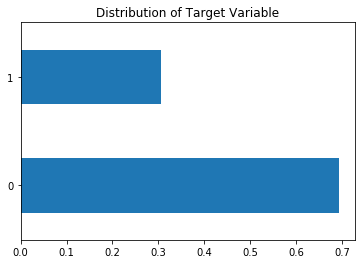

In [26]:
# distribution of target variable
df_train['target'].value_counts(normalize = True).plot(kind='barh',title='Distribution of Target Variable')

In [27]:
# Binary Encdoing
# bin_o and bin_1 need not be converted as these are already converted
# bin_3and bin_4 are binary variables representing T/F and Y/N. We can convert them to 0 or 1.
df['bin_3'] = df['bin_3'].map({'T':1,'F':0})
df['bin_4'] = df['bin_4'].map({'Y':1,'N':0})

In [28]:
# Ordinal Encoding
# ord_0 need not to be converted
# ord_1 and ord_2 has ordinal data. We can manually encode these variables.
# ( ord_3,ord_4,ord_5 are of hight cardinality)

# mapping dict for ord_1 and ord_2
d1 = {'Grandmaster': 5, 'Expert': 4 , 'Novice':1 , 'Contributor':2 , 'Master': 3}
d2 = {'Cold': 2, 'Hot':4, 'Lava Hot': 6, 'Boiling Hot': 5, 'Freezing': 1, 'Warm': 3}

df['ord_1'] = df['ord_1'].map(d1)
df['ord_2'] = df['ord_2'].map(d2)

# medium cardinality columns -- ord_3 and ord_4
df['ord_3'] = df['ord_3'].astype('category')
df['ord_4'] = df['ord_4'].astype('category')

# mapping dict for ord_3 and ord_4
d3 = dict(zip(df['ord_3'],df['ord_3'].cat.codes))
d4 = dict(zip(df['ord_4'],df['ord_4'].cat.codes))

df['ord_3'] = df['ord_3'].map(d3)
df['ord_4'] = df['ord_4'].map(d4)


# high cardinality column -- ord_5
li = sorted(list(set(df['ord_5'].values)))
d5 = dict(zip(li, range(len(li))))  # mapping dict for ord_5
df['ord_5'] = df['ord_5'].map(d5)

In [29]:
# one hot encoding for low cardinality column : nom_0 to nom_4
df = pd.get_dummies(df, columns=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],
                        prefix=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], 
                        drop_first=True)

In [30]:
# encoding hex feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features_hex = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']

for col in features_hex:
    le.fit(df[col])
    df[col] = le.transform(df[col])


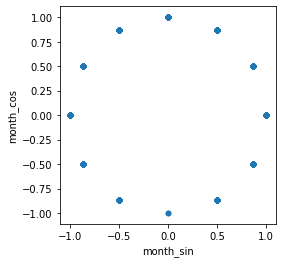

In [31]:
# cyclical features into 2d sin-cos features

df['day_sin'] = np.sin(2*np.pi * df['day']/7)
df['day_cos'] = np.cos(2*np.pi * df['day']/7)
df['month_sin'] = np.sin(2*np.pi * df['month']/12)
df['month_cos'] = np.cos(2*np.pi * df['month']/12)
df.drop(columns=['day','month'],inplace=True)

# plot features in 2d
df.sample(1000).plot.scatter('month_sin','month_cos').set_aspect('equal')

In [38]:
nulls_report(X_train)

,Missing_Values,Missing_Ratio


In [33]:
from sklearn.model_selection import train_test_split

# training , testing and target
y_train = df_train['target']
X_train = df[:len(df_train)].drop(['target'],axis=1)
X_test = df[len(df_train):].drop(['target'],axis=1)


# split train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.001, random_state=0)


In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')

lr_prarams = {'C': [0.100, 0.150, 0.120, 0.125, 0.130, 0.135, 0.140, 0.145, 0.150]}
grid = GridSearchCV(lr,lr_prarams,scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
grid.fit(X_train,y_train)

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs',C=0.14)

In [35]:
lr.fit(X_train,y_train)

LogisticRegression(C=0.14, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
# function to evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


def eval_model(m):
    y_pred = m.predict(X_val)
    ra = roc_auc_score(y_val,y_pred)
    sc = cross_val_score(m,X_train,y_train,scoring="roc_auc",cv=3)
    sm = sc.mean()
    print("ROC_AUC is {0}\nCross Val is {1}".format(ra,sm))

In [44]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=None, tol=1e-4, random_state=1,
                    learning_rate_init=0.1)

mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50,), learning_rate='constant',
              learning_rate_init=0.1, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=None, warm_start=False)

In [19]:
eval_model(mlp)

ROC_AUC is 0.5
Cross Val is 0.5


In [37]:
from sklearn.metrics import confusion_matrix
y_pred = lr.predict(X_val)
confusion_matrix(y_pred,y_val)


array([[204,  72],
       [ 10,  14]], dtype=int64)

In [41]:
lr.predict_proba(X_test)

array([[0.53813293, 0.46186707],
       [0.44002913, 0.55997087],
       [0.62158313, 0.37841687],
       ...,
       [0.39072912, 0.60927088],
       [0.75500462, 0.24499538],
       [0.67898449, 0.32101551]])

In [45]:
# predict probability and generate submission file
y_pred = mlp.predict_proba(X_test)[:, 1]
df_sub = pd.DataFrame({'id':df_test.index,'target':y_pred})
df_sub.to_csv(r'...kaggle\categorical\submission.csv',index=False)